In [1]:
import os

from qcodes import Station, load_or_create_experiment
from qcodes.dataset.plotting import plot_dataset
from qcodes.dataset.data_set import load_by_run_spec
 
import nanotune as nt
from nanotune.tests.mock_classifier import MockClassifer
from nanotune.tuningstages.chargediagram import ChargeDiagram

from sim.data_providers import QcodesDataProvider
from sim.qcodes_mocks import QuantumDotMockInstrument

nt_path = os.path.dirname(os.path.dirname(os.path.abspath(nt.__file__)))

Logging hadn't been started.
Activating auto-logging. Current session state plus future input saved.
Filename       : /Users/jana/.qcodes/logs/command_history.log
Mode           : append
Output logging : True
Raw input log  : False
Timestamping   : True
State          : active
Qcodes Logfile : /Users/jana/.qcodes/logs/210528-92993-qcodes.log


Define databases

In [2]:
db_name_original_data2D = "dot_tuning_sequences.db"
db_folder_original_data = os.path.join(nt_path, "data", "tuning")
chargediagram_path = os.path.join(db_folder_original_data, db_name_original_data2D)

db_name_replay = 'qdsim_test.db'
db_folder_replay = os.getcwd()

Create qc.Station

In [3]:
station = Station()

qd_mock_instrument = QuantumDotMockInstrument()
station.add_component(qd_mock_instrument, name="qdmock")

qdsim = qd_mock_instrument.mock_device

Create the data provider

In [4]:
charge_state_data = QcodesDataProvider(
    input_providers=[qdsim.l_plunger, qdsim.r_plunger], 
    db_path=chargediagram_path, 
    exp_name="GB_Newtown_Dev_1_1", 
    run_id = 19,
)
qd_mock_instrument.drain.set_data_provider(charge_state_data)

In [5]:
ds = nt.Dataset(19, db_name_original_data2D, db_folder_original_data)
range_to_sweep = [
    (min(ds.data.voltage_x.values), max(ds.data.voltage_x.values)),
    (min(ds.data.voltage_y.values), max(ds.data.voltage_y.values)),
]
# range_to_sweep

In [6]:
nt.set_database(db_name_replay, db_folder_replay)
exp = load_or_create_experiment("simtest")

In [7]:

chadiag = ChargeDiagram(
    data_settings={
        'db_name': db_name_replay,
        'db_folder': db_folder_replay,
        'normalization_constants': ds.normalization_constants,
        'segment_size': 0.2,
    },
     setpoint_settings={
        'voltage_precision': 0.01,
        'parameters_to_sweep': [qd_mock_instrument.left_plunger, qd_mock_instrument.right_plunger],
        'safety_voltage_ranges': [(-3, 0)],
        'current_valid_ranges': range_to_sweep,
    },
    readout_methods={'transport': qd_mock_instrument.drain},
    classifiers={
        'singledot': MockClassifer('singledot'),
        'doubledot': MockClassifer('doubledot'),
        'dotregime': MockClassifer('dotregime')},
)

2021-05-28 15:30:55,573 ¦ nanotune.tuningstages.take_data ¦ WARNING ¦ take_data ¦ ramp_to_setpoint ¦ 130 ¦ Unable to ramp to new voltage. It will be set.
2021-05-28 15:30:55,586 ¦ nanotune.tuningstages.take_data ¦ WARNING ¦ take_data ¦ ramp_to_setpoint ¦ 130 ¦ Unable to ramp to new voltage. It will be set.
2021-05-28 15:30:55,599 ¦ nanotune.tuningstages.take_data ¦ WARNING ¦ take_data ¦ ramp_to_setpoint ¦ 130 ¦ Unable to ramp to new voltage. It will be set.
2021-05-28 15:30:55,621 ¦ nanotune.tuningstages.take_data ¦ WARNING ¦ take_data ¦ ramp_to_setpoint ¦ 130 ¦ Unable to ramp to new voltage. It will be set.
2021-05-28 15:30:55,649 ¦ nanotune.tuningstages.take_data ¦ WARNING ¦ take_data ¦ ramp_to_setpoint ¦ 130 ¦ Unable to ramp to new voltage. It will be set.
2021-05-28 15:30:55,670 ¦ nanotune.tuningstages.take_data ¦ WARNING ¦ take_data ¦ ramp_to_setpoint ¦ 130 ¦ Unable to ramp to new voltage. It will be set.
2021-05-28 15:30:55,689 ¦ nanotune.tuningstages.take_data ¦ WARNING ¦ take_d

Starting experimental run with id: 51. 


2021-05-28 15:30:55,773 ¦ nanotune.tuningstages.take_data ¦ WARNING ¦ take_data ¦ ramp_to_setpoint ¦ 130 ¦ Unable to ramp to new voltage. It will be set.
2021-05-28 15:30:55,841 ¦ nanotune.tuningstages.take_data ¦ WARNING ¦ take_data ¦ ramp_to_setpoint ¦ 130 ¦ Unable to ramp to new voltage. It will be set.
2021-05-28 15:30:55,857 ¦ nanotune.tuningstages.take_data ¦ WARNING ¦ take_data ¦ ramp_to_setpoint ¦ 130 ¦ Unable to ramp to new voltage. It will be set.
2021-05-28 15:30:55,901 ¦ nanotune.tuningstages.take_data ¦ WARNING ¦ take_data ¦ ramp_to_setpoint ¦ 130 ¦ Unable to ramp to new voltage. It will be set.
2021-05-28 15:30:55,919 ¦ nanotune.tuningstages.take_data ¦ WARNING ¦ take_data ¦ ramp_to_setpoint ¦ 130 ¦ Unable to ramp to new voltage. It will be set.
2021-05-28 15:30:55,949 ¦ nanotune.tuningstages.take_data ¦ WARNING ¦ take_data ¦ ramp_to_setpoint ¦ 130 ¦ Unable to ramp to new voltage. It will be set.
2021-05-28 15:30:55,977 ¦ nanotune.tuningstages.take_data ¦ WARNING ¦ take_d

Starting experimental run with id: 367. 
Starting experimental run with id: 368. 
Starting experimental run with id: 369. 
Starting experimental run with id: 370. 
Starting experimental run with id: 371. 
Starting experimental run with id: 372. 


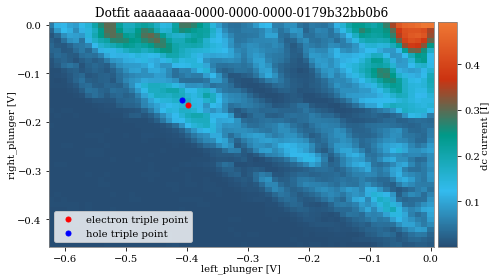

chargediagram: Good result measured. Regime: doubledot. Termination reasons: None. 


In [8]:
tuning_result = chadiag.run_stage()

In [9]:
tuning_result.success

True

In [10]:
# Note that a mock classifier was used, which always returns True == good result
tuning_result.ml_result

{'dot_segments': {367: {'voltage_ranges': [(-0.622073578595318,
     -0.428312955754153),
    (-0.451505016722408, -0.236013986013986)],
   'predicted_regime': 3},
  368: {'voltage_ranges': [(-0.622073578595318, -0.428312955754153),
    (-0.225752508361204, 0.0)],
   'predicted_regime': 3},
  369: {'voltage_ranges': [(-0.418115028236197, -0.224354405395033),
    (-0.451505016722408, -0.236013986013986)],
   'predicted_regime': 3},
  370: {'voltage_ranges': [(-0.418115028236197, -0.224354405395033),
    (-0.225752508361204, 0.0)],
   'predicted_regime': 3},
  371: {'voltage_ranges': [(-0.214156477877077, 0.0),
    (-0.451505016722408, -0.236013986013986)],
   'predicted_regime': 3},
  372: {'voltage_ranges': [(-0.214156477877077, 0.0),
    (-0.225752508361204, 0.0)],
   'predicted_regime': 3}},
 'regime': 'doubledot',
 'quality': True,
 'features': {'transport': {'triple_points': [([0.01446705392538609, None],
     [0.010197927517956007, 0.010261477652782014],
     [-0.397719173200285, 

In [11]:
tuning_result.data_ids

[51]